In [2]:
%load_ext autoreload
import sys
#sys.argv.append("-lc=C:/Workspaces/AIC/simod-master/local_config_files/fido-PC.cfg")
# sys.argv.append("-lc=C:/Workspaces/AIC/simod/local_config_files/fido-nb.cfg")
sys.argv.append("-lc=C:/Workspaces/AIC/simod/local_config_files/fido-PC.cfg")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from simod.init import config
import roadmaptools.inout
import simod.statistics.model.edges as edges
import simod.statistics.comparisons.sensitivity_analysis as sa


INFO:root:Loading config for project RoadmaptoolsConfig (can be overwritten later)
INFO:root:map_dir: C:/AIC Experiment Data/VGA/maps/
osm_source_url: https://s3.amazonaws.com/metro-extracts.mapzen.com/valencia_spain.osm.bz2
osm_map_filename: C:/AIC Experiment Data/VGA/maps/map.osm
filtered_osm_filename: C:/AIC Experiment Data/VGA/maps/map-filtered.osm
geojson_file: C:/AIC Experiment Data/VGA/maps/map.geojson
cleaned_geojson_file: C:/AIC Experiment Data/VGA/maps/map-cleaned.geojson
sanitized_geojson_file: C:/AIC Experiment Data/VGA/maps/map-sanitized.geojson
simplified_file: C:/AIC Experiment Data/VGA/maps/map-simplified.geojson
simplified_file_with_speed: C:/AIC Experiment Data/VGA/maps/map-simplified-speed.geojson
simplified_file_with_speed_and_curvature: C:/AIC Experiment Data/VGA/maps/map-simplified-speed-curvature.geojson
ap_nodes_file: C:/AIC Experiment Data/VGA/maps/nodes.geojson
ap_edges_file: C:/AIC Experiment Data/VGA/maps/edges.geojson
utm_center_lon: 50.0877506
utm_center_l

In [15]:
peak_experiments = {
    'delay_experiments': [
        ["ih-max_delay_3_min", "ih", "ih-max_delay_5_min", "ih-max_delay_6_min", "ih-max_delay_7_min"],
        ["vga-max_delay_3_min", "vga"],
        ["vga-lim-max_delay_3_min", "vga-lim", "vga-lim-max_delay_5_min", "vga-lim-max_delay_6_min", "vga-lim-max_delay_7_min"],
        ["vga-pnas-max_delay_3_min", "vga-pnas", "vga-pnas-max_delay_5_min", "vga-pnas-max_delay_6_min", "vga-pnas-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["ih", "ih-batch_60_s", "ih-batch_90_s", "ih-batch_120_s"],
        ["vga"],
        ["vga-lim", "vga-lim-batch_60s", "vga-lim-batch_90s", "vga-lim-batch_120s"],
        ["vga-pnas", "vga-pnas-batch_60s", "vga-pnas-batch_90s", "vga-pnas-batch_120s"]
    ],
    'capacity_experiments':[
        ['ih-capacity_2', "ih", 'ih-capacity_10'],
        ['vga-capacity_2', "vga"],
        ['vga-lim-capacity_2', "vga-lim", 'vga-lim-capacity_10'],
        ['vga-pnas-capacity_2', "vga-pnas", 'vga-pnas-capacity_10']
    ]
}

off_peak_experiments = {
    'delay_experiments': [
        ["sw-ih-max_delay_3_min", "sw-ih", "sw-ih-max_delay_5_min", "sw-ih-max_delay_6_min", "sw-ih-max_delay_7_min"],
        ["sw-vga-max_delay_3_min", "sw-vga", "sw-vga-max_delay_5_min", "sw-vga-max_delay_6_min"],
        ["sw-vga-lim-max_delay_3_min", "sw-vga-lim", "sw-vga-lim-max_delay_5_min", "sw-vga-lim-max_delay_6_min", "sw-vga-lim-max_delay_7_min"],
        ["sw-vga-pnas-max_delay_3_min", "sw-vga-pnas", "sw-vga-pnas-max_delay_5_min", "sw-vga-pnas-max_delay_6_min", "sw-vga-pnas-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["sw-ih", "sw-ih-batch_60_s", "sw-ih-batch_90_s", "sw-ih-batch_120_s"],
        ["sw-vga", "sw-vga-batch_60s", "sw-vga-batch_90s", "sw-vga-batch_120s"],
        ["sw-vga-lim", "sw-vga-lim-batch_60s", "sw-vga-lim-batch_90s", "sw-vga-lim-batch_120s"],
        ["sw-vga-pnas", "sw-vga-pnas-batch_60s", "sw-vga-pnas-batch_90s", "sw-vga-pnas-batch_120s"]
    ],
    'capacity_experiments':[
        ['sw-ih-capacity_2', "sw-ih", 'sw-ih-capacity_10'],
        ['sw-vga-capacity_2', "sw-vga", 'sw-vga-capacity_10'],
        ['sw-vga-lim-capacity_2', "sw-vga-lim", 'sw-vga-lim-capacity_10'],
        ['sw-vga-pnas-capacity_2', "sw-vga-pnas", 'sw-vga-pnas-capacity_10']
    ]
}

manhattan_experiments = {
    'delay_experiments': [
        ["ih-max_delay_3_min", "ih-start_1830-real_speeds", "ih-start_1830-real_speeds-delay_5_min", "ih-max_delay_6_min", "ih-max_delay_7_min"],
        ["vga-max_delay_3_min", "vga_gap_0002-start_1830-real_speeds", "vga_gap_0002-start_1830-real_speeds-delay_5_min", "vga-max_delay_6_min"],
        ["vga-lim-max_delay_3_min", "vga-lim", "vga-lim-max_delay_5_min", "vga-lim-max_delay_6_min", "vga-lim-max_delay_7_min"],
        ["vga-pnas-unlimeted_vehicles-max_delay_3_min", "vga-pnas_unlimeted_vehicles-start_1830-real_speeds", "vga-pnas-unlimeted_vehicles-max_delay_5_min", "vga-pnas-unlimeted_vehicles-max_delay_6_min", "vga-pnas-unlimeted_vehicles-max_delay_7_min"]
    ],
    'batch_experiments': [
        ["ih-start_1830-real_speeds", "ih-batch_60_s", "ih-batch_90_s", "ih-batch_120_s"],
        ["vga_gap_0002-start_1830-real_speeds", "vga-batch_60_s", "vga-batch_90_s", "vga-batch_120_s"],
        ["vga-lim", "vga-lim-batch_60_s", "vga-lim-batch_90_s", "vga-lim-batch_120_s"],
        ["vga-pnas_unlimeted_vehicles-start_1830-real_speeds", "vga-pnas-unlimeted_vehicles-batch_60_s", "vga-pnas-unlimeted_vehicles-batch_90_s", "vga-pnas-unlimeted_vehicles-batch_120_s"]
    ],
    'capacity_experiments':[
        ['ih-capacity_2', "ih-start_1830-real_speeds", 'ih-capacity_10'],
        ['vga-capacity_2', "vga_gap_0002-start_1830-real_speeds", 'vga-capacity_10'],
        ['vga-lim-capacity_2', "vga-lim", 'vga-lim-capacity_10'],
        ['vga-pnas-unlimeted_vehicles-capacity_2', "vga-pnas_unlimeted_vehicles-start_1830-real_speeds", 'vga-pnas-unlimeted_vehicles-capacity_10']
    ]
}
# for exp_set in manhattan_experiments.values():
#     for index, method in enumerate(exp_set):
#         new_list =  [f"Manhattan/{name}" for name in method]
#         exp_set[index] = new_list

In [5]:
loaded_edges = roadmaptools.inout.load_geojson(config.agentpolis.map_edges_filepath)
edge_data = edges.make_data_frame(loaded_edges)

[11:14:04]: Loading geojson file from: C:\AIC Experiment Data\VGA\maps\edges.geojson


In [6]:
x_values_delay = [3, 4, 5, 6, 7]
x_values_batch = [30, 60, 90, 120]
x_values_capacity = [2, 5, 10]

x_values = [x_values_batch, x_values_delay, x_values_capacity]

# Peak Experiments

In [7]:
sa.check_experiments(peak_experiments)
distance_data, comp_time_data, delay_data = sa.load_experiments(peak_experiments, edge_data)

[11:14:19]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\ih-max_delay_3_min\ridesharing.csv to dataframe
[11:14:26]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\ih\ridesharing.csv to dataframe
[11:14:31]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\ih-max_delay_5_min\ridesharing.csv to dataframe
[11:14:35]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\ih-max_delay_6_min\ridesharing.csv to dataframe
[11:14:39]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\ih-max_delay_7_min\ridesharing.csv to dataframe
[11:14:44]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-max_delay_3_min\ridesharing.csv to dataframe
[11:14:48]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga\ridesharing.csv to dataframe
[11:14:54]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\vga-lim-max_delay_3_min\ridesharing.csv to dataframe
[11:14:59]: Loading csv file from: C:\AIC Experim

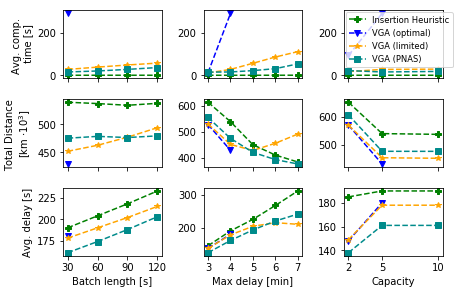

In [8]:
sa.plot_sensitivity_analysis(peak_experiments, distance_data, comp_time_data, delay_data, x_values)

# Off-peak Experiments

In [9]:
sa.check_experiments(off_peak_experiments)
offpeak_speed_data, offpeak_tt_data, offpeak_delay_data = sa.load_experiments(off_peak_experiments, edge_data)

[11:17:21]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-ih-max_delay_3_min\ridesharing.csv to dataframe
[11:17:22]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-ih\ridesharing.csv to dataframe
[11:17:24]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-ih-max_delay_5_min\ridesharing.csv to dataframe
[11:17:25]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-ih-max_delay_6_min\ridesharing.csv to dataframe
[11:17:27]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-ih-max_delay_7_min\ridesharing.csv to dataframe
[11:17:28]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_3_min\ridesharing.csv to dataframe
[11:17:30]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga\ridesharing.csv to dataframe
[11:17:31]: Loading csv file from: C:\AIC Experiment Data\VGA\experiments\sw-vga-max_delay_5_min\ridesharing.csv to dataframe
[11:17:32]: Loading csv file 

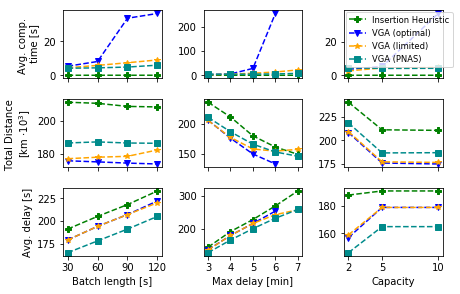

In [10]:
sa.plot_sensitivity_analysis(off_peak_experiments, offpeak_speed_data, offpeak_tt_data, offpeak_delay_data, x_values, "off_peak")

# Manhattan Experiments

In [11]:
loaded_edges_manhattan = roadmaptools.inout.load_geojson("C:\AIC Experiment Data\VGA Manhattan\maps/edges.geojson")
edge_data_manhattan = edges.make_data_frame(loaded_edges_manhattan)

[11:21:11]: Loading geojson file from: C:\AIC Experiment Data\VGA Manhattan\maps\edges.geojson


In [16]:
man_exp_dir = r"C:\AIC Experiment Data\VGA Manhattan\experiments/"
sa.check_experiments(manhattan_experiments, man_exp_dir)
manhattan_speed_data, manhattan_tt_data, manhattan_delay_data = sa.load_experiments(manhattan_experiments, edge_data_manhattan, man_exp_dir)

[11:27:47]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\ih-max_delay_3_min\ridesharing.csv to dataframe
[11:27:49]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\ih-start_1830-real_speeds\ridesharing.csv to dataframe
[11:27:50]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\ih-start_1830-real_speeds-delay_5_min\ridesharing.csv to dataframe
[11:27:51]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\ih-max_delay_6_min\ridesharing.csv to dataframe
[11:27:52]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\ih-max_delay_7_min\ridesharing.csv to dataframe
[11:27:53]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga-max_delay_3_min\ridesharing.csv to dataframe
[11:27:54]: Loading csv file from: C:\AIC Experiment Data\VGA Manhattan\experiments\vga_gap_0002-start_1830-real_speeds\ridesharing.csv to dataframe
[11:27:55]: Loading csv file fro

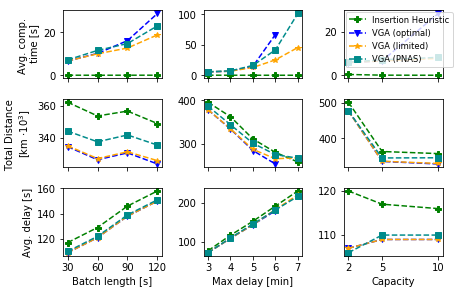

In [17]:
sa.plot_sensitivity_analysis(manhattan_experiments, manhattan_speed_data, manhattan_tt_data, manhattan_delay_data, x_values, "manhattan")

In [17]:
%autoreload
